https://www.kaggle.com/code/danielyumanin/ab-test-data-analysis/edit

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
path = 'AB_Test_Results.csv'
df = pd.read_csv(path)
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [10]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [7]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [12]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [13]:
# taking look at the distribution of the number of unique groups for each user
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

In [14]:
# also look in relative terms
double_variant_count / double_variant_count.sum()

VARIANT_NAME
1    0.756325
2    0.243675
Name: count, dtype: float64

In [15]:
# first, let's see which users have 1 ab test group
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
# and then take only these users
single_variant_users = single_variant_users[single_variant_users]

In [16]:
# leave only records with users with the 1st ab test group
df = df[df['USER_ID'].isin(single_variant_users.index)]
# just in case, check that the number of users matches what it was before the exception
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

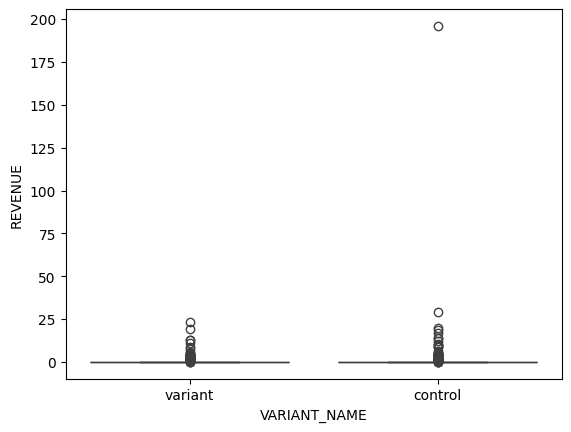

In [17]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

In [18]:
df.sort_values(by='REVENUE', ascending=False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99
